In [6]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import nltk
import os
import nltk.corpus


In [ ]:

df = pd.read_csv('IMDB Dataset.csv', header=0, sep=",")

df = df.iloc[690:4690] #no correr mas de una vez
df['sentiment'] = df['sentiment'].replace({'negative': 0, 'positive': 1})

nltk.download('punkt')
nltk.download('punkt_tab')

In [ ]:
from nltk.tokenize import word_tokenize
def tokenization(text):
  tokens = word_tokenize(text.lower())
  return tokens

from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
def stopWords(tokens):
  a = set(stopwords.words("english"))
  text1 = [x.lower() for x in tokens]
  sws = [x for x in text1 if x not in a]
  return sws

from nltk.stem import PorterStemmer
def stemming(tokens):
  pst = PorterStemmer()
  text = []
  for word in tokens:
    text.append(pst.stem(word))
  return text


In [9]:
df2 = df
df2['review'] = df2['review'].apply(tokenization)
df2['review'] = df2['review'].apply(stopWords)
df2['review'] = df2['review'].apply(stemming)

In [ ]:
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(df2['review'], df2['sentiment'], test_size=0.2, random_state=99)


print("Tamaño del conjunto de entrenamiento:", len(X_train2))
print("Tamaño del conjunto de prueba:", len(X_test2))


In [ ]:
!pip install nlpaug
nltk.download('wordnet')
nltk.download('omw-1.4')
import random
import nlpaug.augmenter.word as naw

In [ ]:
df3 = pd.read_csv('IMDB Dataset.csv', header=0, sep=",")
df3 = df3.iloc[690:4690]
df3['sentiment'] = df3['sentiment'].replace({'negative': 0, 'positive': 1})

##df3.to_csv('non_augmented_data.csv', index=False)

df3['review'] = df3['review'].apply(tokenization)
df3['review'] = df3['review'].apply(stopWords)

from nltk.corpus import wordnet

def get_synonym(word):
    synonyms = wordnet.synsets(word)
    if synonyms:
        lemmas = synonyms[0].lemmas()
        for lemma in lemmas:
            if lemma.name().lower() != word.lower():
                return lemma.name().replace('_', ' ')
    return word

augmented_data = []

for index, row in df3.iterrows():
    text = row['review']
    label = row['sentiment']
    if isinstance(text, list) and len(text) >= 3:
        chosen_words = random.sample(text, 3)
    else:
        chosen_words = text

    new_words = []
    for w in text:
      if w in chosen_words:
        new_words.append(get_synonym(w))
      else:
        new_words.append(w)
    augmented_data.extend([(new_words, label)])

    new_words = text.copy()
    idx1, idx2 = random.sample(range(len(text)), 2)
    new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
    augmented_data.extend([(new_words, label)])

augmented_df = pd.DataFrame(augmented_data, columns=['review', 'sentiment'])
final_df = pd.concat([df3, augmented_df], ignore_index=True)

In [13]:
final_df['review'] = final_df['review'].apply(stemming)

X_train3, X_test3, y_train3, y_test3 = train_test_split(final_df['review'], final_df['sentiment'], test_size=0.2, random_state=99)


# Ahora puedes usar train_df para entrenar y test_df para evaluar tu modelo
print("Tamaño del conjunto de entrenamiento:", len(X_train3))
print("Tamaño del conjunto de prueba:", len(X_test3))

Tamaño del conjunto de entrenamiento: 9600
Tamaño del conjunto de prueba: 2400


In [ ]:
# Preprocesamiento del texto
tokenizer = Tokenizer(num_words=200) # Ajusta el número de palabras según tus datos
tokenizer.fit_on_texts(X_train3)
secuencias = tokenizer.texts_to_sequences(X_train3)
secuencias_padding = pad_sequences(secuencias)

# Definir el modelo LSTM
modelo = keras.Sequential([
    keras.layers.Embedding(200, 30, input_length=secuencias_padding.shape[1]),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo
modelo.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
modelo.fit(secuencias_padding, y_train3, epochs=1) # Ajusta el número de épocas según tus datos

C:\Users\Wert\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


300/300 ━━━━━━━━━━━━━━━━━━━━ 56s 180ms/step - accuracy: 0.6212 - loss: 0.6306


75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step
Exactitud: 0.7508333333333334
Precisión: 0.7573822825219473
Sensibilidad (Recall): 0.7634754625905068
Puntuación F1: 0.7604166666666666


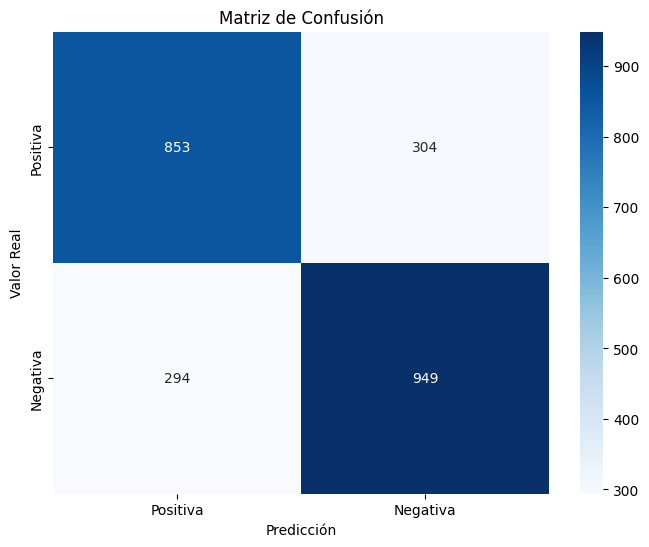

In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

secuencia_nueva = tokenizer.texts_to_sequences(X_test3)
secuencia_padding_nueva = pad_sequences(secuencia_nueva, maxlen=secuencias_padding.shape[1]) # Asegúrate de que tenga la misma longitud que las secuencias de entrenamiento
y_predict = modelo.predict(secuencia_padding_nueva)

# Convertir las probabilidades predichas a clases (0 o 1)
y_pred_classes = (y_predict > 0.5).astype(int)

# Calcular las métricas
accuracy = accuracy_score(y_test3, y_pred_classes)
precision = precision_score(y_test3, y_pred_classes)
recall = recall_score(y_test3, y_pred_classes)
f1 = f1_score(y_test3, y_pred_classes)

print(f"Exactitud: {accuracy}")
print(f"Precisión: {precision}")
print(f"Sensibilidad (Recall): {recall}")
print(f"Puntuación F1: {f1}")


# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test3, y_pred_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Positiva", "Negativa"], yticklabels=["Positiva", "Negativa"])
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión")
plt.show()